## What makes a successful movie?

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import deque

In [4]:
GENRES = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 
'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

In [5]:
# data loading and preprocessing
df1 = pd.read_pickle("mov-1.pkl")
df2 = pd.read_pickle("mov-2.pkl")
df3 = pd.read_pickle("mov-3.pkl")
movie_df = pd.concat([df1,df2, df3]).drop_duplicates().reset_index(drop=True)
movie_df = movie_df[movie_df[movie_df.columns[6:]].sum(axis = 1) != 0]
movie_df = movie_df[movie_df['Year'] <= 2010]
movie_df.head()

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Mystery,Genre_News,Genre_Reality-TV,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Talk-Show,Genre_Thriller,Genre_War,Genre_Western
0,The Flying Saucer,3.8,1950,301,NaN,Both the CIA and KGB investigate UFOs in Alask...,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,The File on Thelma Jordon,7.0,1950,1523,NaN,Assistant district attorney Cleve Marshall fal...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Traveling Saleswoman,6.3,1950,25,NaN,"In this western comedy, the King Soap Company ...",1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Davy Crockett, Indian Scout",5.5,1950,191,NaN,"Davy Crockett (not the famous Alamo hero, but ...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Cry Murder,5.8,1950,6,NaN,A young actress has retired from films to marr...,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
#remove genres
generes = movie_df.columns[6:]
genre_count = movie_df.iloc[:,6:].sum()
genres_to_remove= movie_df.iloc[:,6:].columns[(genre_count < 200)]
try:
    movie_df = movie_df.drop(genres_to_remove, axis = 1)
except:
    pass
movie_df
# for genre in GENRES:
    
#     if((movie_df["Genre_"+genre] == 0).all()):
#         genres_to_remove.append(genre)
# print(genres_to_remove)
# formatted = ["Genre_" + genre for genre in genres_to_remove]
# print(formatted)
# movie_df = movie_df.drop(formatted, axis = 1)
# movie_df.head

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western
0,The Flying Saucer,3.8,1950,301,NaN,Both the CIA and KGB investigate UFOs in Alask...,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,The File on Thelma Jordon,7.0,1950,1523,NaN,Assistant district attorney Cleve Marshall fal...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Traveling Saleswoman,6.3,1950,25,NaN,"In this western comedy, the King Soap Company ...",1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,"Davy Crockett, Indian Scout",5.5,1950,191,NaN,"Davy Crockett (not the famous Alamo hero, but ...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Cry Murder,5.8,1950,6,NaN,A young actress has retired from films to marr...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,The Great Rupert,6.7,1950,743,NaN,A little squirrel with lots of charm accidenta...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Bells of Coronado,6.3,1950,129,NaN,Roy is an insurance investigator looking into ...,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
7,Montana,6.2,1950,901,NaN,An Australian sheepman comes to Montana lookin...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,The Nevadan,6.3,1950,584,NaN,A mysterious stranger crosses paths with an ou...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,The Blonde Bandit,6.8,1950,21,NaN,Add a Plot,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# parse the gross

def parse_gross(s):    
    try:
        if (s[-1]=="M"):
            return (float(s[1:-1]))
    except:
        return np.nan    
movie_df["Gross"] = movie_df["Gross"].apply(parse_gross)
# df["Votes"] = pd.to_numeric(df["Votes"])
# df["Votes"] = pd.to_numeric(df["Votes"])


## Popularity calculation

In [8]:
def get_values(df):
    v = []
    R = []
    for genre in df.columns[6:-1]:
        v1 = sum(df[df[genre] == 1]['Votes'])
        r1 = np.mean(df[df[genre] == 1]['Rating'])
        R.append(r1)
        v.append(v1)
    m = np.mean(df['Votes'])
    C = np.mean(df['Rating'])
    return np.asarray(R), np.asarray(v), m, C
def true_bayesian_estimate(df):
    R, v, m, C = get_values(df)
    return (v/(v+m))*R + (m/(v+m))*C
def true_bayesian_estimate_1(df):
    R = df["Rating"]
    v = df["Votes"]
    m = v.quantile([.25, .5, .75])[0.25]
    C = (R).mean()
    return (v/(v+m))*R + (m/(v+m))*C

In [9]:
ps = true_bayesian_estimate_1(movie_df)
ps = np.nan_to_num(ps)
movie_df = movie_df.assign(Popularity = pd.Series(ps).values.astype("float"))


In [10]:
# split the data into years
dfs = []
years = list(range(1950, 2000, 10))
for start in range(1950, 2010, 10):
    dfs.append(movie_df[np.logical_and(movie_df['Year'] >= start, movie_df['Year'] < (start + 10))])

### is the rating normal distributed?

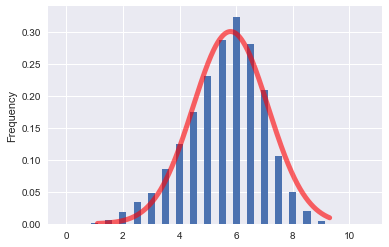

In [96]:
from scipy.stats import norm

r = movie_df['Rating']
r.plot(kind='hist',histtype = 'bar', align = "left",rwidth = 0.5,bins=[i*0.5 for i in range(23)], normed = True)
x = np.linspace(r.min(), r.max(), r.shape[0])
rv = norm(loc = np.mean(r), scale = np.std(r))
plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


From the dirstribution of the ratings. We found the ratings centered around 6

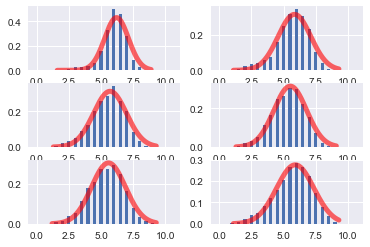

In [97]:
i = 0
for col in dfs:
    ax = plt.subplot2grid((3,2), (i//2, i%2))
    i = i + 1
    r = col['Rating']
    ax.hist(r, histtype = 'bar', align = "left",rwidth = 0.5,bins=[i*0.5 for i in range(23)], normed=True)
    
    x = np.linspace(r.min(), r.max(), r.shape[0])

    rv = norm(loc = np.mean(r), scale = np.std(r))
    ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:
weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
Where:
 - R = average rating for across movie = (Rating)
 - v = number of votes for across movie = (votes)
 - m = a good number of votes to rely on the rating based on votes (m as the average number of votes)
 - C = the mean ratings of all movies

## How popularity varies across genres

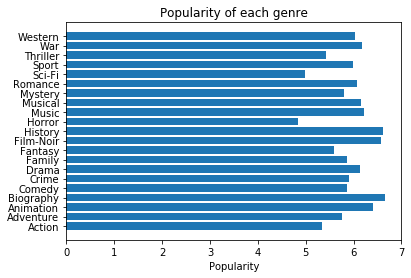

In [13]:
y = true_bayesian_estimate(movie_df)
labels = list(movie_df.columns[6:-1])
labels = [x.replace('Genre_','') for x in labels]
y = np.nan_to_num(y)
plt.barh(labels, y)
plt.xlabel('Popularity')
plt.title("Popularity of each genre")
plt.show()

In [14]:
indx = (-y).argsort()[:4]
top_genres = [labels[i] for i in indx ]
top_genres

['Biography', 'History', 'Film-Noir', 'Animation']

In [15]:
import scipy.stats as st

for i in range(len(top_genres)):
    a = movie_df[movie_df[''.join(['Genre_' ,top_genres[i]])] == 1]["Popularity"]
    b = movie_df[movie_df[''.join(['Genre_' ,top_genres[i]])] == 0]["Popularity"]
    ## Cross Checking with the internal scipy function
    t2, p2 = st.ttest_ind(a,b)
    print("t = " + str(t2))
    print("p = " + str(p2))

t = 21.382532259218365
p = 1.211337525941477e-100
t = 15.613275639254097
p = 9.992623594019654e-55
t = 14.27855734636415
p = 4.301388884286685e-46
t = 11.998355416725964
p = 4.358555890585483e-33


Hypothesis testing From the hypothesis testing, for each genre in the top genres, it has the popularity larger than the other genres.

TODO: Reformat and explanation

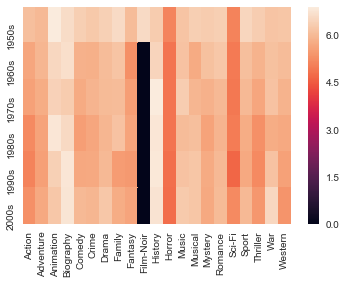

In [16]:
import seaborn as sns; sns.set()
all_years = pd.DataFrame(columns = [ col.split("_")[1] for col in movie_df.columns[6:-1]])
for i in range(6):
    df = dfs[i]
    y = true_bayesian_estimate(df)
    y = np.nan_to_num(y)
    all_years.loc[i] = y
all_years.index = [str(start)+"s"  for start in range(1950, 2010, 10)]
# print(all_years)
ax = sns.heatmap(all_years)

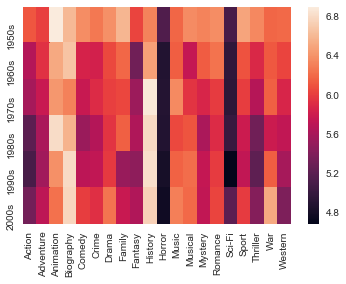

In [17]:

all_years_without_fn = all_years.drop(["Film-Noir"], axis = 1)
ax = sns.heatmap(all_years_without_fn)

In [18]:
# film - noir

## How year affects the market (ratings,  gross, popularity)
Time Series

## The average gross over years
To find the trend of the gross over years, apply the sliding average on this time series data to smooth out short-term flucatuations and find the longer-term trend.

In [19]:

class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k = k
        self.s = deque(maxlen = 2*k + 1)
        self.s.extend([None] * k)
        self.sum = 0.0
        self.num = 0.0
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        self.s.append(x)
        if x is not None:
            self.sum = self.sum + x
            self.num = self.num + 1
        if len(self.s) == 2*(self.k) + 1:
            slidingavg = self.sum/(self.num)
            if (not (self.s[0] is None)):
                self.num = self.num - 1
                self.sum = self.sum - self.s[0]

            return slidingavg
        return None
    

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    if k == 0:
        return s
    sa = SlidingAverage(k)
    s1 = pd.Series()
    snew = [val for val in map(sa.update, s) if val is not None]  
    snew.extend([val for val in map(sa.update, [None]*k) if val is not None])
    s1 = s1.append(pd.Series(snew))
    return s1

In [20]:
subdf = movie_df.dropna()


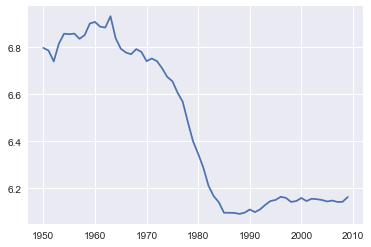

In [21]:
pop_y = subdf.groupby(['Year'])['Popularity'].mean()
pop_y_slide_average = compute_sliding_averages(pd.Series(pop_y),5)
plt.plot(range(1950, 2010), pop_y_slide_average)
plt.show()

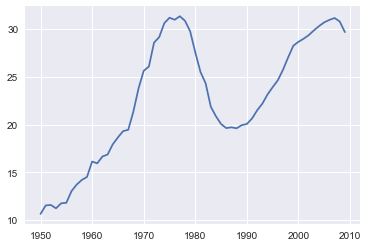

In [22]:
gross_y = subdf.groupby(['Year'])['Gross'].mean()
gross_y_slide_average = compute_sliding_averages(pd.Series(gross_y),5)
plt.plot(range(1950, 2010), gross_y_slide_average)
plt.show()

#### df.columns

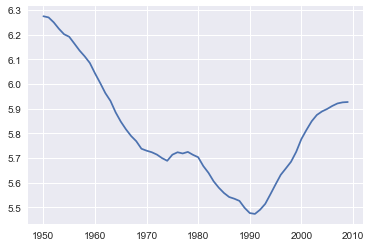

In [23]:
rating_y1 = movie_df.groupby(['Year'])['Rating'].mean()
rating_y1_slide_average = compute_sliding_averages(pd.Series(rating_y1),5)
plt.plot(range(1950, 2010), rating_y1_slide_average)
plt.show()

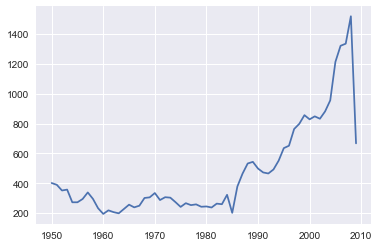

In [24]:
rating_y1 = movie_df.groupby(['Year'])['Name'].count()
plt.plot(range(1950, 2010),rating_y1)
plt.show()

## Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

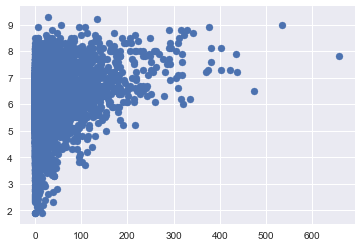

In [80]:
#ax= sns.regplot(x=subdf["Popularity"], y = subdf["Gross"],lowess=True)
plt.scatter(movie_df["Gross"].values.reshape(-1, 1), movie_df["Popularity"])
plt.show()

In [81]:
from regressors import stats
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=True, normalize=False)  
subdf = movie_df.dropna()
X = np.asarray(subdf["Gross"]).reshape(-1,1)
y = np.asarray(subdf["Popularity"])
lm.fit(X, y)
print(lm.coef_)
print(stats.coef_pval(lm, X, y))
stats.summary(lm, X, y)

[0.00512698]
[0. 0.]
Residuals:
Min      1Q  Median      3Q     Max
-2.3669 -0.6797 -0.3987 -0.1755  4.9582


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept  6.787755    0.041151  164.9456      0.0
x1          0.005127    0.000454   11.3017      0.0
---
R-squared:  0.05637,    Adjusted R-squared:  0.05576
F-statistic: 93.42 on 1 features


In [82]:
lm = LinearRegression(fit_intercept=True, normalize=False)  
generes = subdf.columns[5:]

subdf["Year"] = subdf["Year"] - 1940
X1 = np.asarray(subdf.iloc[:,[2]+list(range(6,subdf.shape[1] - 2))+ [4]], dtype='float')
y1 = np.asarray(subdf["Popularity"], dtype='float')
lm.fit(X1, y1)

coefs = lm.coef_
pvals = stats.coef_pval(lm, X1, y1)
stats.summary(lm, X1, y1)

Residuals:
Min      1Q  Median      3Q     Max
-2.6818 -0.6343 -0.2143  0.2976  4.9016


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept  7.200497    0.147373  48.8588  0.000000
x1         -0.020582    0.000687 -29.9621  0.000000
x2         -0.468430    0.098064  -4.7768  0.000002
x3         -0.115226    0.094692  -1.2169  0.223842
x4          0.727759    0.157612   4.6174  0.000004
x5          0.213436    0.110395   1.9334  0.053369
x6         -0.183886    0.073046  -2.5174  0.011922
x7          0.177262    0.082762   2.1418  0.032360
x8          1.014097    0.075948  13.3524  0.000000
x9         -0.671561    0.130601  -5.1421  0.000000
x10        -0.003542    0.131052  -0.0270  0.978443
x11         0.182514    0.497299   0.3670  0.713661
x12        -0.036576    0.142049  -0.2575  0.796834
x13        -0.559921    0.143262  -3.9084  0.000097
x14        -0.165209    0.162304  -1.0179  0.308882
x15         0.266307    0.222906   1.1947  0.232383
x16         0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [84]:
variable_names = [subdf.columns[2]]+ list(subdf.columns[6:subdf.shape[1] - 2]) + ["Gross"]
zipped = list(zip(variable_names, coefs, pvals[1:]))
important_factors = [ (name, coef, pval) for (name, coef, pval) in zipped if pval < 0.05]
important_factors

[('Year', -0.020582217958693846, 0.0),
 ('Genre_Action', -0.46843028340687454, 1.9479616542028566e-06),
 ('Genre_Animation', 0.7277585024482374, 4.2033873906e-06),
 ('Genre_Comedy', -0.18388551974789186, 0.011921899702487249),
 ('Genre_Crime', 0.17726186821805912, 0.03236043623299656),
 ('Genre_Drama', 1.0140971427871448, 0.0),
 ('Genre_Family', -0.6715609140048144, 3.0596823630268943e-07),
 ('Genre_Horror', -0.5599208447198716, 9.688963233323022e-05),
 ('Genre_Mystery', 0.42578542629468974, 0.0007645028045017987),
 ('Gross', 0.007287755921614458, 0.0)]

## Does the movie summary signify the movie quality 

In [76]:
# extraodinary films
import nltk, re
from nltk.corpus import movie_reviews
from collections import Counter
from nltk.tokenize import word_tokenize
import random

def helper(x):
    if x < 4:
        return "neg"
    if x < 7:
        return np.nan
    return "pos"

ind = movie_df['Popularity'].apply(helper)
df_text = movie_df
df_text['ind'] = ind.values
df_text = df_text.drop("Gross", axis = 1)
df_text = df_text.dropna()
stratified = df_text.groupby("ind")
res = []
def to_list(w):
    w = re.sub(r'[^\w\s]','',w)
    return w.lower().split()
documents = list(zip(df_text.Summary.apply(to_list), df_text.ind))
random.shuffle(documents)
all_words = list(filter(lambda x: len(x) >1, (re.sub(r'[^\w\s]',''," ".join(df_text["Summary"])).lower()).split()))
all_words = nltk.FreqDist(all_words)
word_features = list(all_words.most_common(3000))
word_features = [w for (w, c) in word_features]
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features
featuresets = [(find_features(rev), category) for (rev, category) in documents]
training_set = featuresets[:20000]
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [77]:
classifier.show_most_informative_features(10)
testing_set = featuresets[20000:25000]
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

Most Informative Features
                      ii = True              pos : neg    =     18.9 : 1.0
                 british = True              pos : neg    =     15.7 : 1.0
                 weekend = True              neg : pos    =     14.7 : 1.0
                    hell = True              neg : pos    =     13.8 : 1.0
                  crazed = True              neg : pos    =     11.9 : 1.0
                 zombies = True              neg : pos    =     11.7 : 1.0
                   beast = True              neg : pos    =     10.9 : 1.0
                   widow = True              pos : neg    =     10.5 : 1.0
                 english = True              pos : neg    =     10.5 : 1.0
              determined = True              pos : neg    =     10.1 : 1.0
Classifier accuracy percent: 0
